In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from selenium import webdriver as wb
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import datetime
import time
from wordcloud import WordCloud

## 비트코인과 안정자산, 위험자산의 상관관계 분석
- 데이터 산출 기간
    - 제도 편입 전 : 2014.09.01 ~ 2019.12.31
    - 제도 편입 후 : 2021.01.01 ~ 2024.06.06
- 안전자산 비교군 : 금, 달러
- 위험자산 비교군 : 원유
- 데이터 출처 : Yahoo Finance

In [2]:
# 기간
start_date = "2014-09-01"
end_date = "2019-12-31"
news_date_list = []

# 종목
bitcoin = "BTC-USD"
gold = "GC=F"
usd = "EURUSD=X"
wti = "CL=F"

# 일간 티커 데이터 수집
def ticker_data(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de)
    result["change"] = result["Adj Close"].diff()
    result["daily_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna() # NaN 포함 행 삭제
    return result

# 주간 티커 데이터 수집
def ticker_data_wk(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de, interval = "1wk")
    result["weekly_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna()
    return result

# 일별 수정 종가 (Adj Close) 추출 함수
def daily_adj_close(tk_name, ds, de) :
    result = yf.download(tk_name, ds, de)
    return result["Adj Close"]

# 일별 수익률 (daily_return) 추출 함수
def daily_return_rate(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de)
    return result["daily_return"]

# 주간 수익률 (weekly_return) 추출 함수
def weekly_return_rate(tk_name, ds, de) :
    result = ticker_data_wk(tk_name, ds, de)
    return result["weekly_return"]

# 비트코인과 티커 간의 상관성 산출
def corr_bit(tk_name, ds, de) :
    result = weekly_return_rate(bitcoin, ds, de) / weekly_return_rate(tk_name, ds, de)
    result = result.dropna()
    return result

# 계산식 for 선형 회귀
def lin_cal(tk_name, ds, de) :
    tk2019 = ticker_data(tk_name, ds, de) # 제도 편입 전 기간의 티커 데이터 수집
    std2019 = tk2019[tk2019.index == "2019-11-15"] # 기준이 되는 날짜의 행 추출
    std2019 = std2019["Adj Close"].values[0] # 해당 행의 수정 종가
    result = (ticker_data(tk_name, ds, de)["Adj Close"] / std2019) * 100 # 티커의 수정 종가 컬럼과 연산
    return result

# 티커 생성 시 호출 함수
def ticker_call(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de) # 일간 티커 데이터 수집
    result["chg_rat_exp_2019"] = lin_cal(tk_name, ds, de) # 선형 회귀 산출을 위해 연산된 컬럼 추가
    return result

# 선형 회귀 계수 산출
def lin_data(tk_name, ds, de) :
    bit_col = ticker_call(bitcoin, ds, de)["chg_rat_exp_2019"]
    tk_col = ticker_call(tk_name, ds, de)["chg_rat_exp_2019"]
    
    result = pd.concat([bit_col, tk_col], axis = 1)
    result.columns = ["bit", "tk"]
    result = result.dropna()
    
    model = stats.linregress(result["bit"], result["tk"]) # 선형 회귀 계수 객체 생성
    dict_lin = {
        "slope" : model.slope,
        "intercept" : model.intercept,
        "rvalue" : model.rvalue,
        "pvalue" : model.pvalue,
        "stderr" : model.stderr,
        "intercept_stderr" : model.intercept_stderr
    }
    result_lin = pd.DataFrame(list(dict_lin.values()), index = dict_lin.keys())
    return result_lin

In [3]:
# 비트코인의 일간 티커 데이터 수집
bit_ticker = ticker_call(bitcoin, start_date, end_date)
bit_ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,change,daily_return,chg_rat_exp_2019
Date,,,,,,,,,
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-32.894012,-7.192558,4.998121
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-29.644012,-6.984265,4.649039
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,14.108002,3.573492,4.815172
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-10.082977,-2.465854,4.696436
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600,3.330994,0.835210,4.735662
...,...,...,...,...,...,...,...,...,...
2019-12-26,7274.799316,7388.302734,7200.386719,7238.966797,7238.966797,22787010034,-36.188965,-0.497432,85.244624
2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360996,51.121582,0.706200,85.846621
2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,27.901855,0.382737,86.175188


In [4]:
# 비교군 일간 티커 데이터 수집
ticker = ticker_call(usd, start_date, end_date)
ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,change,daily_return,chg_rat_exp_2019
Date,,,,,,,,,
2014-09-02,1.313198,1.313731,1.311180,1.313198,1.313198,0,0.000414,0.031519,119.159550
2014-09-03,1.313094,1.316099,1.312405,1.313198,1.313198,0,0.000000,0.000000,119.159550
2014-09-04,1.314924,1.315500,1.292420,1.315097,1.315097,0,0.001900,0.144664,119.331930
2014-09-05,1.293042,1.298819,1.292674,1.293276,1.293276,0,-0.021821,-1.659280,117.351880
2014-09-08,1.295203,1.295874,1.293169,1.295337,1.295337,0,0.002061,0.159327,117.538853
...,...,...,...,...,...,...,...,...,...
2019-12-24,1.109299,1.109755,1.107064,1.109385,1.109385,0,0.001401,0.126473,100.665627
2019-12-25,1.109139,1.110864,1.107788,1.109016,1.109016,0,-0.000369,-0.033268,100.632138
2019-12-26,1.109509,1.110494,1.108279,1.109545,1.109545,0,0.000529,0.047715,100.680155


## 통계적 수치를 위한 단순 선형 회귀
- 기울기 (Slope)
- 절편 (Intercept)
- 상관계수 (R-value)
    - 1 : 완벽한 양의 상관관계. 두 변수는 완벽하게 비례해서 증가
    - 0.7 ~ 0.9 : 강한 양의 상관관계
    - 0.5 ~ 0.7 : 중간 정도의 양의 상관관계
    - 0.3 ~ 0.5 : 약한 양의 상관관계
    - 0 : 상관관계 없음
    - -0.3 ~ -0.5 : 약한 음의 상관관계
    - -0.5 ~ -0.7 : 중간 정도의 음의 상관관계
    - -0.7 ~ -0.9 : 강한 음의 상관관계
    - -1 : 완벽한 음의 상관관계. 두 변수는 완벽하게 반비례해서 변화
- 유의확률 (P-value) : 일반적으로 P-value가 0.05보다 작으면 결과가 통계적으로 유의미하다고 판단
- 표준오차 (Standard Error)
- 절편의 표준오차 (Intercept Standard Error)

#### ✅ 안전/안정적 자산 비교군 추가
- iShares 20+ Year Treasury Bond ETF : 미국 국채 ETF, 미국의 장기 국채에 투자하여 안정적인 수익을 추구, 종목코드 "TLT"
- iShares iBoxx $ Investment Grade Corporate Bond ETF : 미국 투자등급 회사채에 투자하는 ETF, 종목코드 "LQD"
- Duke Energy : 전력 및 천연가스 서비스를 제공하는 유틸리티 부문 공공 주식, 종목코드 "DUK"
- Gold ETF : 나스닥 100 지수를 추종하는 ETF, 금 가격에 연동되어 금에 투자하는 효과를 제공하는 ETF, 종목코드 "GLD"

#### ✅ 위험 자산 비교군 추가
- Brent oil :  종목코드 "BZ=F"
- Tesla :  종목코드 "TSLA"
- Dow Jones Industrial Average : 다우존스 산업 평균 지수, 주로 대형 기업들로 구성되어 있어, 시장 전체보다는 주로 대형주 및 산업을 대표, 종목코드 "^DJI"
- Nasdaq-100 Index : 나스닥 100 지수를 추종하는 ETF, 종목코드 "QQQ"
- Emerging Markets ETF : 중국, 인도, 브라질 등 신흥 시장의 주식에 투자하는 ETF, 종목코드 "EEM"

In [5]:
# 선형 회귀 계수 산출
# 안전 자산, 안정적 자산
gold_lin = lin_data(gold, start_date, end_date)
tlt_lin = lin_data("TLT", start_date, end_date)
lqd_lin = lin_data("LQD", start_date, end_date)
duk_lin = lin_data("DUK", start_date, end_date)
gold_etf_lin = lin_data("GLD", start_date, end_date)
usd_lin = lin_data(usd, start_date, end_date)
# 위험 자산
wti_lin = lin_data(wti, start_date, end_date)
brent_lin = lin_data("BZ=F", start_date, end_date)
tsla_lin = lin_data("TSLA", start_date, end_date)
dj_lin = lin_data("^DJI", start_date, end_date)
nasdq_lin = lin_data("QQQ", start_date, end_date)
em_etf_lin = lin_data("EEM", start_date, end_date)

df_lin = pd.concat([gold_lin, tlt_lin, lqd_lin, duk_lin, gold_etf_lin, usd_lin, wti_lin, brent_lin, tsla_lin, dj_lin, nasdq_lin, em_etf_lin], axis = 1)
df_lin.columns = ["Gold", "US ETF", "US CP ETF", "Duke", "Gold ETF", "EUR/USD", "WTI", "Brent", "Tesla", "Dow Jones", "Nasdaq-100 Index", "Emerging Markets ETF"]
df_lin

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Gold,US ETF,US CP ETF,Duke,Gold ETF,EUR/USD,WTI,Brent,Tesla,Dow Jones,Nasdaq-100 Index,Emerging Markets ETF
slope,8.806704e-02,6.787029e-02,8.905956e-02,1.583925e-01,8.016024e-02,3.280201e-02,1.718436e-01,1.990042e-01,1.620654e-01,0.247431,0.300952,1.978790e-01
intercept,8.209459e+01,8.270976e+01,8.221339e+01,7.543820e+01,8.335276e+01,1.016624e+02,8.637515e+01,8.449606e+01,6.865113e+01,65.785866,54.789443,8.041761e+01
rvalue,6.159197e-01,4.859755e-01,7.169547e-01,6.754047e-01,5.867376e-01,3.322024e-01,4.252167e-01,4.774820e-01,4.816401e-01,0.858083,0.833105,7.814238e-01
pvalue,2.034304e-139,9.153094e-80,2.492793e-210,7.195195e-178,7.596030e-124,8.815676e-37,1.926592e-59,1.851714e-76,3.506555e-78,0.000000,0.000000,2.837134e-274
stderr,3.094584e-03,3.349376e-03,2.376278e-03,4.745724e-03,3.035859e-03,2.513448e-03,1.004486e-02,1.006405e-02,8.091998e-03,0.004063,0.005483,4.336097e-03
intercept_stderr,1.984151e-01,2.148593e-01,1.524360e-01,3.044337e-01,1.947475e-01,1.613809e-01,6.448459e-01,6.460924e-01,5.190940e-01,0.260654,0.351726,2.781565e-01


## 데이터 시각화

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


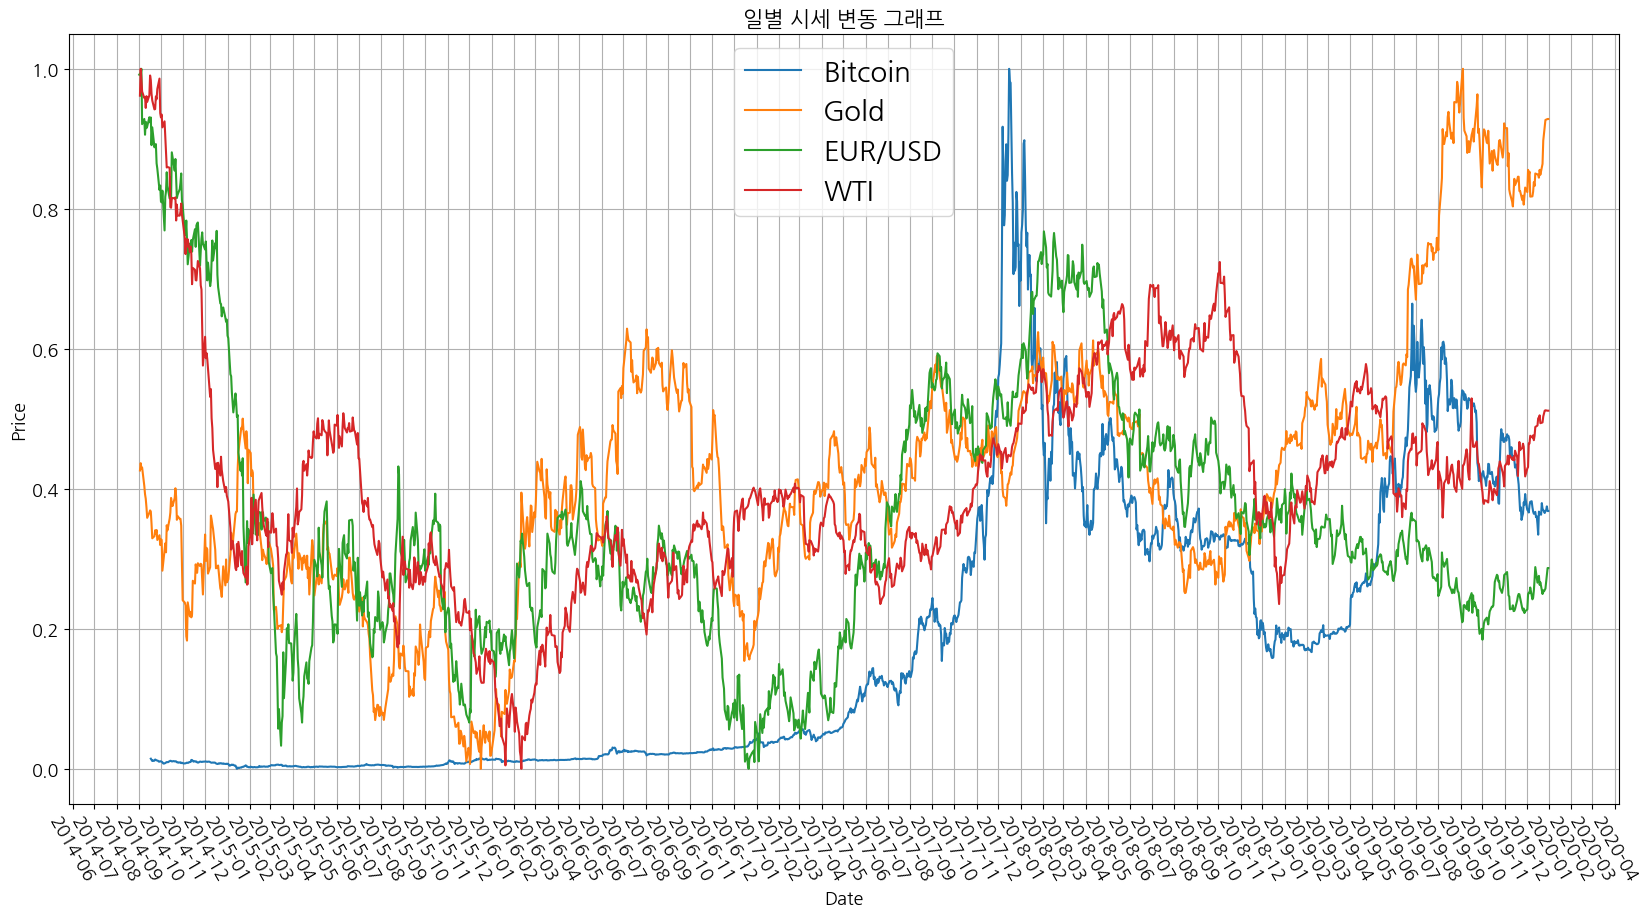

In [6]:
# daily price change graph
scaler = MinMaxScaler()
all_dates = pd.date_range(start = start_date, end = end_date, freq = "D")

# interpolate() : 결측치 보간
y1_series = daily_adj_close(bitcoin, start_date, end_date).reindex(all_dates).interpolate()
y2_series = daily_adj_close(gold, start_date, end_date).reindex(all_dates).interpolate()
y3_series = daily_adj_close(usd, start_date, end_date).reindex(all_dates).interpolate()
y4_series = daily_adj_close(wti, start_date, end_date).reindex(all_dates).interpolate()

# 스케일링할 데이터 모양 변경
y1 = y1_series.values.reshape(-1, 1)
y2 = y2_series.values.reshape(-1, 1)
y3 = y3_series.values.reshape(-1, 1)
y4 = y4_series.values.reshape(-1, 1)

dates = y1_series.index # 날짜 추출

plt.rc("font", family="NanumGothic", size=13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize=(20, 10))
plt.plot(dates, scaler.fit_transform(y1), label="Bitcoin")
plt.plot(dates, scaler.fit_transform(y2), label="Gold")
plt.plot(dates, scaler.fit_transform(y3), label="EUR/USD")
plt.plot(dates, scaler.fit_transform(y4), label="WTI")
plt.legend(loc="best", prop={"size": 20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=300)
plt.grid(True)
plt.title("일별 시세 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


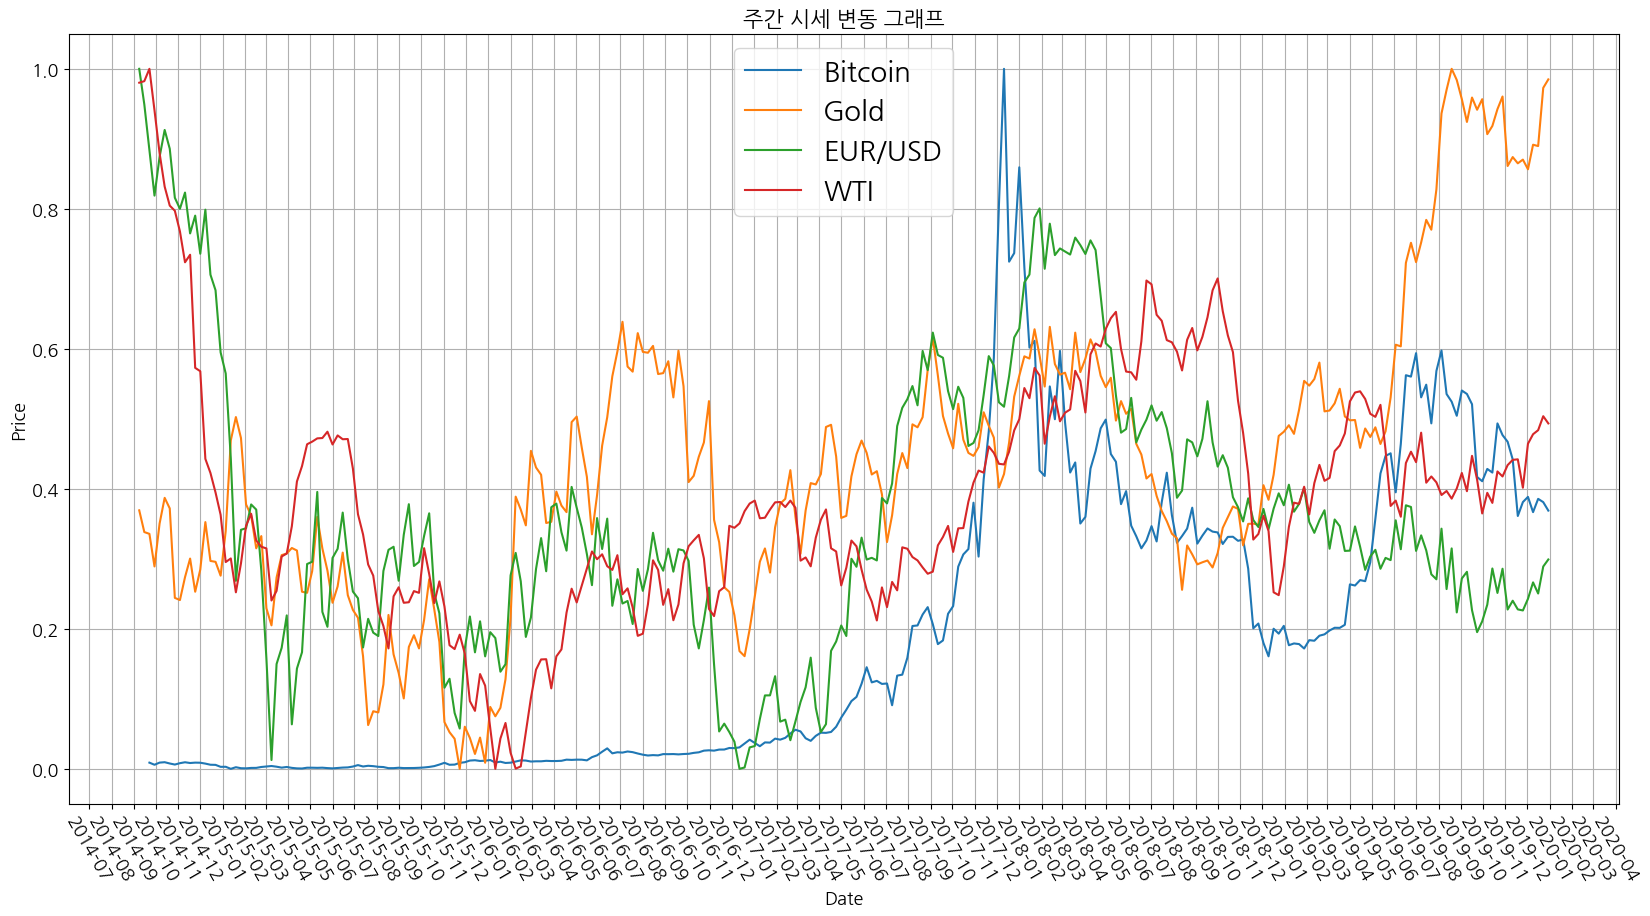

In [7]:
# weekly price change graph
y1_wk = ticker_data_wk(bitcoin, start_date, end_date)["Adj Close"]
y2_wk = ticker_data_wk(gold, start_date, end_date)["Adj Close"]
y3_wk = ticker_data_wk(usd, start_date, end_date)["Adj Close"]
y4_wk = ticker_data_wk(wti, start_date, end_date)["Adj Close"]

# 스케일링할 데이터 모양 변경
y1 = y1_wk.values.reshape(-1, 1)
y2 = y2_wk.values.reshape(-1, 1)
y3 = y3_wk.values.reshape(-1, 1)
y4 = y4_wk.values.reshape(-1, 1)

dates = y1_wk.index # 날짜 추출

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(y1_wk.index, scaler.fit_transform(y1), label = "Bitcoin")
plt.plot(y2_wk.index, scaler.fit_transform(y2), label = "Gold")
plt.plot(y3_wk.index, scaler.fit_transform(y3), label = "EUR/USD")
plt.plot(y4_wk.index, scaler.fit_transform(y4), label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("주간 시세 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


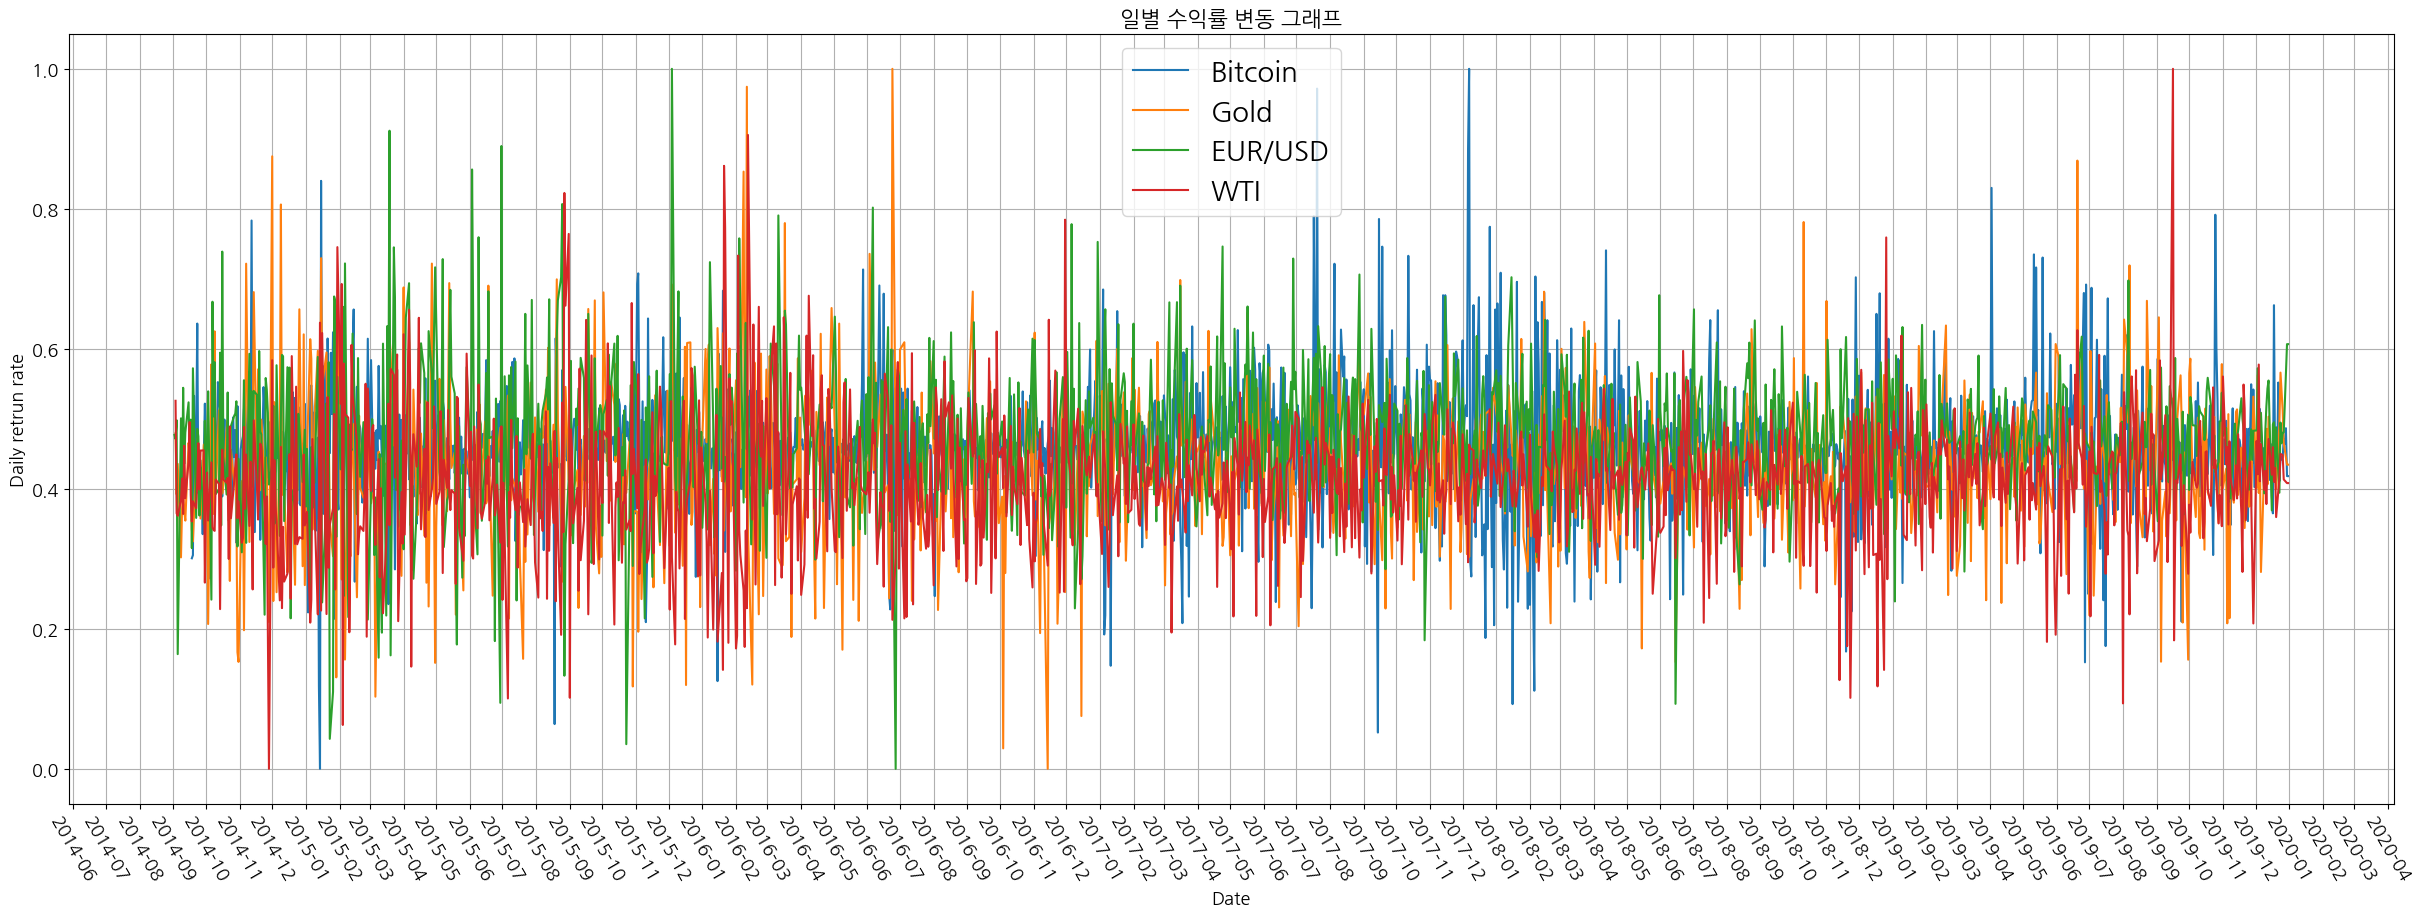

In [8]:
# daily return rate change graph
# 일별 수익률(=증감률)의 변동성 확인
# interpolate() : 결측치 보간
d_y1 = daily_return_rate(bitcoin, start_date, end_date).reindex(all_dates).interpolate()
d_y2 = daily_return_rate(gold, start_date, end_date).reindex(all_dates).interpolate()
d_y3 = daily_return_rate(usd, start_date, end_date).reindex(all_dates).interpolate()
d_y4 = daily_return_rate(wti, start_date, end_date).reindex(all_dates).interpolate()


# 스케일링할 데이터 모양 변경
y1 = d_y1.values.reshape(-1, 1)
y2 = d_y2.values.reshape(-1, 1)
y3 = d_y3.values.reshape(-1, 1)
y4 = d_y4.values.reshape(-1, 1)

dates = d_y1.index # 날짜 추출

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (30, 10))
plt.plot(dates, scaler.fit_transform(y1), label = "Bitcoin")
plt.plot(dates, scaler.fit_transform(y2), label = "Gold")
plt.plot(dates, scaler.fit_transform(y3), label = "EUR/USD")
plt.plot(dates, scaler.fit_transform(y4), label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Daily retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("일별 수익률 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


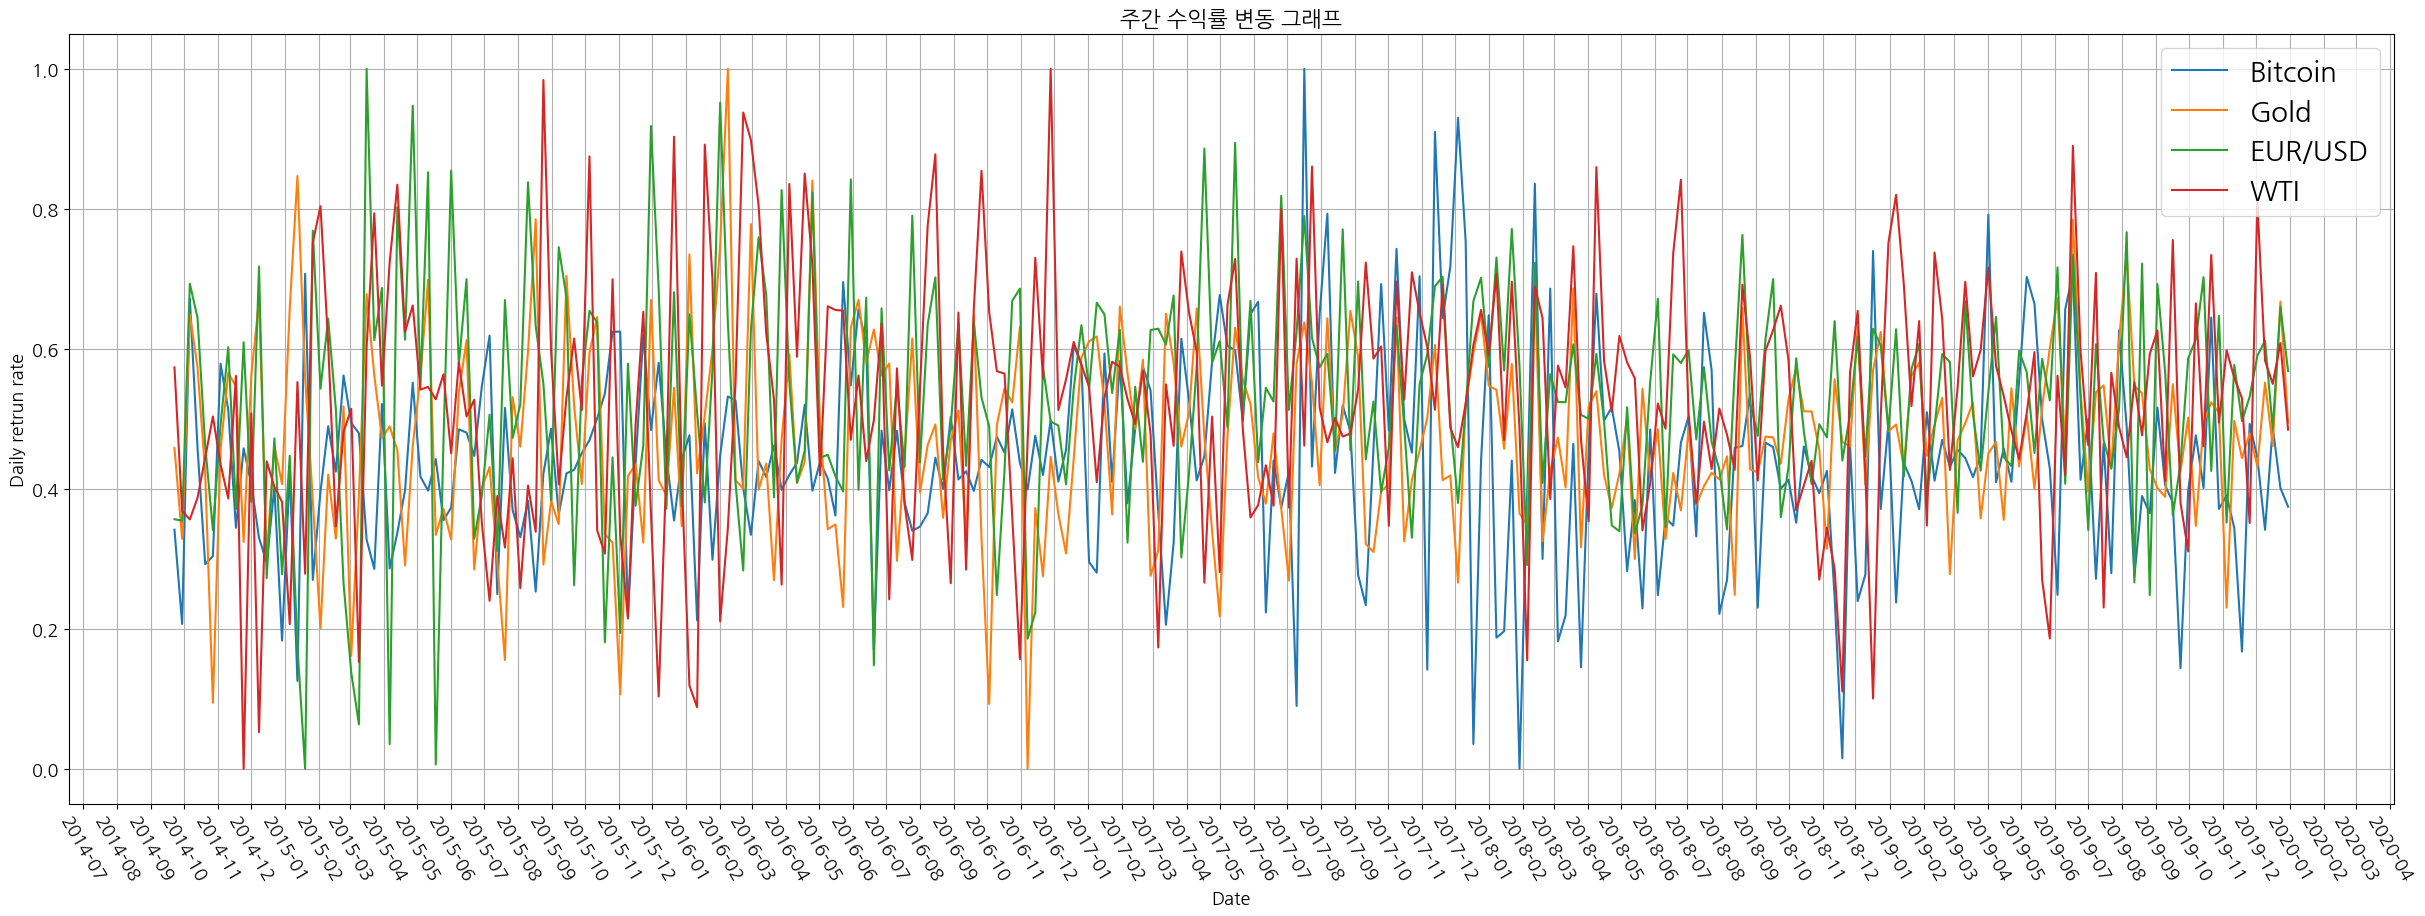

In [9]:
# weekly return rate change graph
# 주간 수익률 (=증감률)의 변동성 확인
# interpolate() : 결측치 보간
w_y1 = weekly_return_rate(bitcoin, start_date, end_date).interpolate()
w_y2 = weekly_return_rate(gold, start_date, end_date).interpolate()
w_y3 = weekly_return_rate(usd, start_date, end_date).interpolate()
w_y4 = weekly_return_rate(wti, start_date, end_date).interpolate()

# 각 데이터의 길이가 일정하지 않아, 하나의 DataFrame으로 병합 후 결측치 제거
concat_data = pd.concat([w_y1, w_y2, w_y3, w_y4], axis = 1).dropna()

# 병합한 DataFrame으로 스케일링
scaled_data = scaler.fit_transform(concat_data)

# Extract scaled data for each column
scaled_y1 = scaled_data[:, 0]  # Bitcoin
scaled_y2 = scaled_data[:, 1]  # Gold
scaled_y3 = scaled_data[:, 2]  # EUR/USD
scaled_y4 = scaled_data[:, 3]  # WTI

dates = concat_data.index # 날짜 추출

plt.figure(figsize=(30, 10))
plt.plot(dates, scaled_y1, label="Bitcoin")
plt.plot(dates, scaled_y2, label="Gold")
plt.plot(dates, scaled_y3, label="EUR/USD")
plt.plot(dates, scaled_y4, label="WTI")

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Daily retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("주간 수익률 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


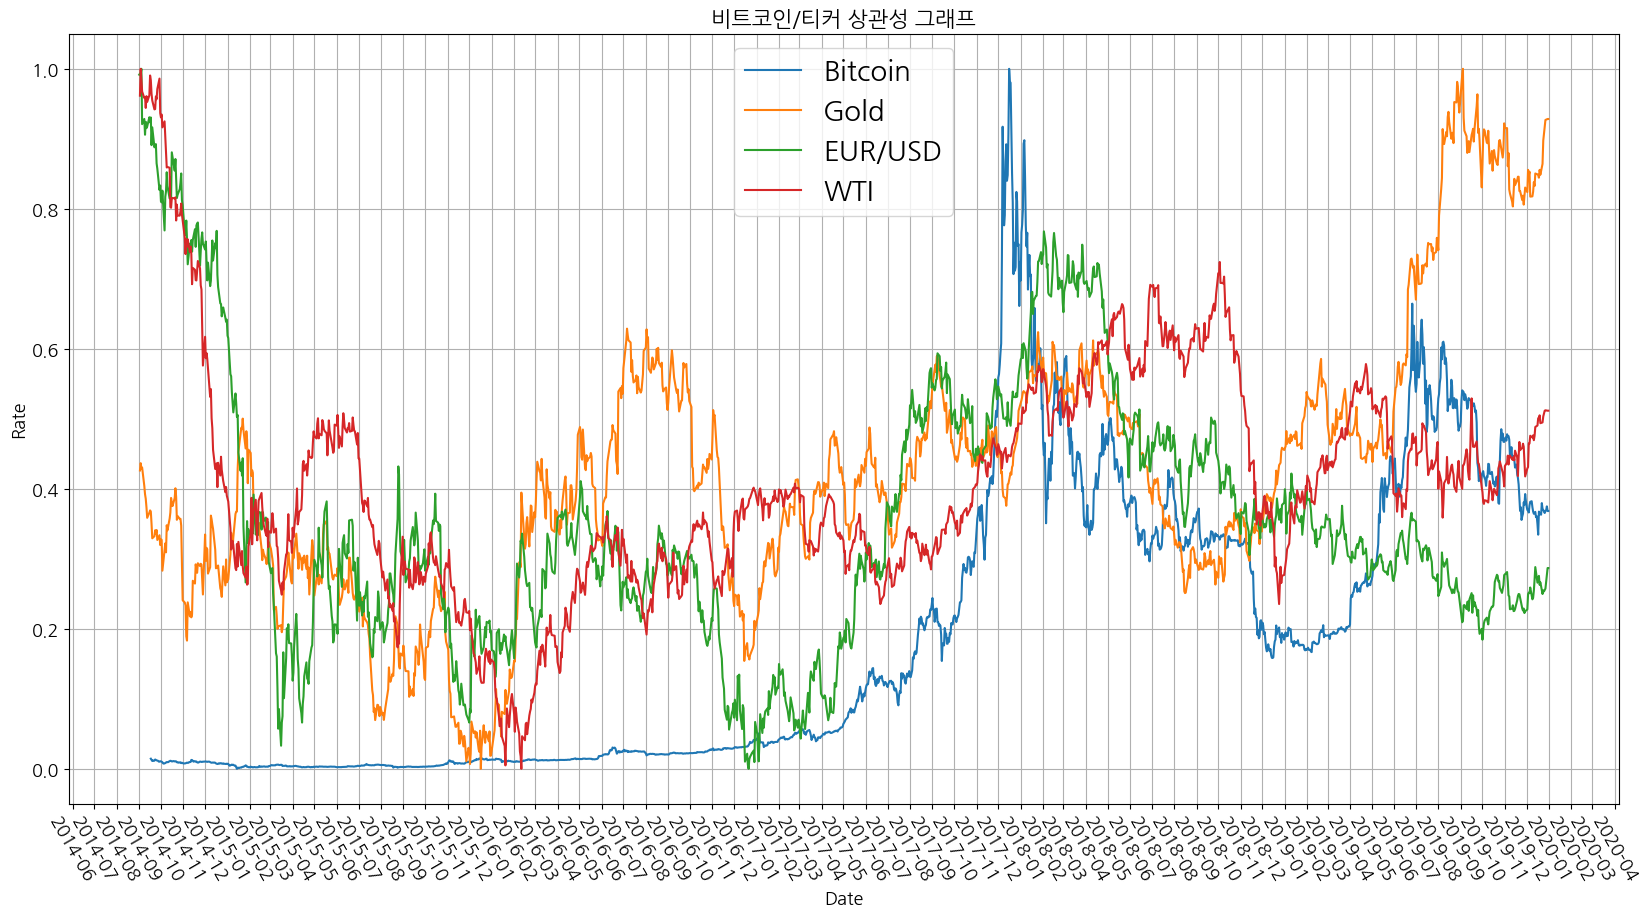

In [10]:
# 상관성 그래프 시각화
# weekly_return_rate(Bitcoin) / weekly_return_rate(ticker)
corr_y1 = corr_bit(bitcoin, start_date, end_date).reindex(all_dates).interpolate()
corr_y2 = corr_bit(gold, start_date, end_date).reindex(all_dates).interpolate()
corr_y3 = corr_bit(usd, start_date, end_date).reindex(all_dates).interpolate()
corr_y4 = corr_bit(wti, start_date, end_date).reindex(all_dates).interpolate()

y1 = y1_series.values.reshape(-1, 1)
y2 = y2_series.values.reshape(-1, 1)
y3 = y3_series.values.reshape(-1, 1)
y4 = y4_series.values.reshape(-1, 1)

dates = corr_y1.index
plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(dates, scaler.fit_transform(y1), label = "Bitcoin")
plt.plot(dates, scaler.fit_transform(y2), label = "Gold")
plt.plot(dates, scaler.fit_transform(y3), label = "EUR/USD")
plt.plot(dates, scaler.fit_transform(y4), label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("비트코인/티커 상관성 그래프")
plt.show()

## 피어슨 상관 계수
    - 각 종목들 간 상관 계수 분석
    - 상관 계수의 수치가 0.3 ~ 0.7 이면 상관관계가 있다고 봄 (약함 ~ 중간 정도의 양의 상관관계)

In [11]:
# 비트코인과 티커의 상관 계수 산출
df_close = pd.concat([bit_ticker["Adj Close"], ticker["Adj Close"]], axis = 1)
df_close.columns = ["bit_adj_close", "tk_adj_close"]
df_close = df_close.dropna()
corr_coefficient = np.corrcoef(df_close["bit_adj_close"], df_close["tk_adj_close"])[0, 1]
print(f"비트코인과의 상관 계수 : {corr_coefficient:.4f}")

비트코인과의 상관 계수 : 0.3322


### 🔥 HeatMap 생성

#### ✅ 안전/안정적 자산 비교군 추가
- iShares 20+ Year Treasury Bond ETF : 미국 국채 ETF, 미국의 장기 국채에 투자하여 안정적인 수익을 추구, 종목코드 "TLT"
- iShares iBoxx $ Investment Grade Corporate Bond ETF : 미국 투자등급 회사채에 투자하는 ETF, 종목코드 "LQD"
- Duke Energy : 전력 및 천연가스 서비스를 제공하는 유틸리티 부문 공공 주식, 종목코드 "DUK"
- Gold ETF : 나스닥 100 지수를 추종하는 ETF, 금 가격에 연동되어 금에 투자하는 효과를 제공하는 ETF, 종목코드 "GLD"

#### ✅ 위험 자산 비교군 추가
- Brent oil :  종목코드 "BZ=F"
- Tesla :  종목코드 "TSLA"
- Dow Jones Industrial Average : 다우존스 산업 평균 지수, 주로 대형 기업들로 구성되어 있어, 시장 전체보다는 주로 대형주 및 산업을 대표, 종목코드 "^DJI"
- Nasdaq-100 Index : 나스닥 100 지수를 추종하는 ETF, 종목코드 "QQQ"
- Emerging Markets ETF : 중국, 인도, 브라질 등 신흥 시장의 주식에 투자하는 ETF, 종목코드 "EEM"

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


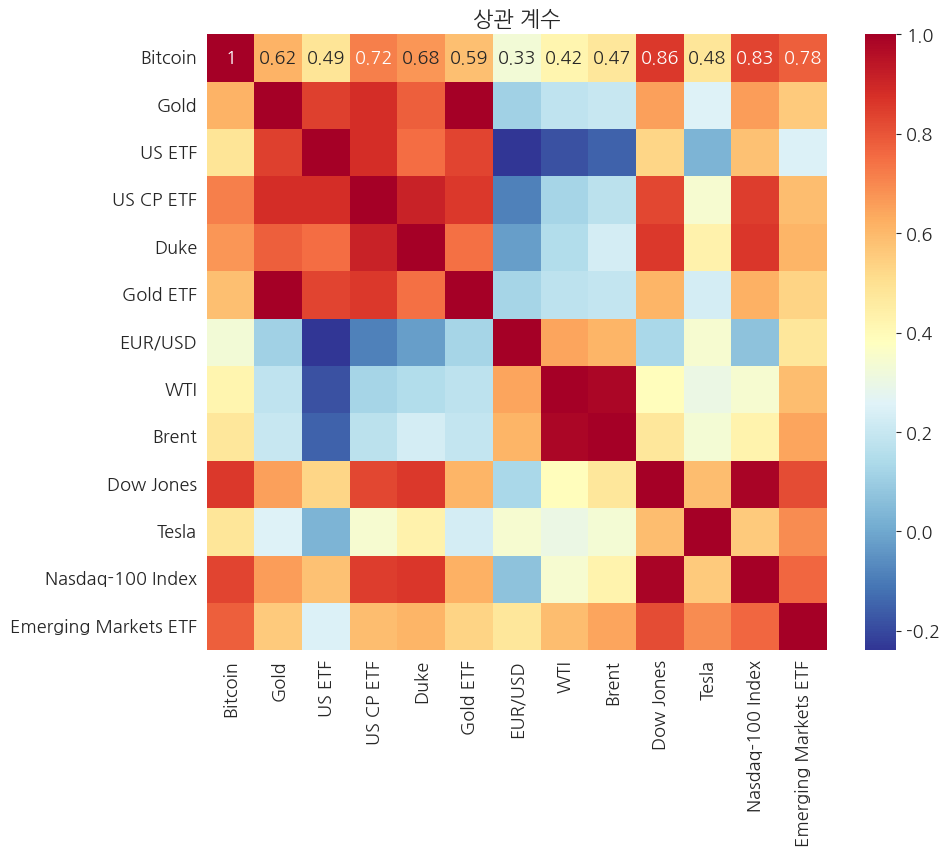

In [12]:
# 상관 계수 시각화 - HeatMep
corr_matrix = pd.DataFrame({"Bitcoin" : daily_adj_close(bitcoin, start_date, end_date),
                            # 안전 자산, 안정적 자산
                            "Gold" : daily_adj_close(gold, start_date, end_date),
                            "US ETF" : daily_adj_close("TLT", start_date, end_date),
                            "US CP ETF" : daily_adj_close("LQD", start_date, end_date),
                            "Duke" : daily_adj_close("DUK", start_date, end_date),
                            "Gold ETF" : daily_adj_close("GLD", start_date, end_date),
                            "EUR/USD" : daily_adj_close(usd, start_date, end_date),
                            # 위험 자산
                            "WTI" : daily_adj_close(wti, start_date, end_date),
                            "Brent" : daily_adj_close("BZ=F", start_date, end_date),
                            "Dow Jones" : daily_adj_close("^DJI", start_date, end_date),
                            "Tesla" : daily_adj_close("TSLA", start_date, end_date),
                            "Nasdaq-100 Index" : daily_adj_close("QQQ", start_date, end_date),
                            "Emerging Markets ETF" : daily_adj_close("EEM", start_date, end_date)}).corr()

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = "RdYlBu_r", cbar = True)
plt.title("상관 계수")
plt.show()

## 뉴스 크롤링
- 티커의 변동성이 큰 날짜와 특정 날짜의 네이버 뉴스 크롤링
- 검색 키워드 : "{티커} 환율/시세/가격 등"

In [13]:
# 주간 티커 데이터 수집
ticker_wk = ticker_data_wk(usd, start_date, end_date)
ticker_wk

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,weekly_return
Date,,,,,,,
2014-09-08,1.295203,1.298094,1.286107,1.296546,1.296546,0,0.099840
2014-09-15,1.296075,1.298000,1.282791,1.283746,1.283746,0,-0.987200
2014-09-22,1.284076,1.289930,1.266994,1.267347,1.267347,0,-1.277481
2014-09-29,1.267636,1.271456,1.250159,1.250985,1.250985,0,-1.291021
2014-10-06,1.251502,1.279301,1.251502,1.264894,1.264894,0,1.111842
...,...,...,...,...,...,...,...
2019-12-02,1.101771,1.111346,1.100376,1.106100,1.106100,0,0.380268
2019-12-09,1.105780,1.118693,1.105400,1.111999,1.111999,0,0.533311
2019-12-16,1.112520,1.117319,1.107432,1.108000,1.108000,0,-0.359643


In [14]:
# 상승, 하락이 관계 없는 주간 변동성 추출
ticker_chg_abs = (ticker_wk["weekly_return"]).abs()
# 변동성 큰 구간 TOP10
large_chg = ticker_chg_abs.sort_values(ascending = False)
top_chg = large_chg[:10]
top_chg

Date
2015-01-19    3.809355
2015-05-18    3.765715
2015-04-06    3.558548
2015-03-09    3.359363
2015-03-16    3.291291
2016-02-01    2.947862
2015-04-27    2.916176
2015-03-02    2.830809
2016-06-20    2.758983
2015-11-30    2.711787
Name: weekly_return, dtype: float64

In [15]:
# 뉴스 크롤링 날짜 추가
top_lst = top_chg.index.to_list()
news_date_list.extend(top_lst)
news_date_list

[Timestamp('2015-01-19 00:00:00'),
 Timestamp('2015-05-18 00:00:00'),
 Timestamp('2015-04-06 00:00:00'),
 Timestamp('2015-03-09 00:00:00'),
 Timestamp('2015-03-16 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2015-04-27 00:00:00'),
 Timestamp('2015-03-02 00:00:00'),
 Timestamp('2016-06-20 00:00:00'),
 Timestamp('2015-11-30 00:00:00')]

In [16]:
news_titles = []
search = input("뉴스 검색어 입력 (ex. 달러 환율) : ")

driver = wb.Chrome()
driver.maximize_window()
for i in tqdm(range(len(news_date_list))) :
    # 뉴스 검색 기간 : 지정된 날짜 포함 일주일
    news_ds = news_date_list[i]
    news_de = news_ds + datetime.timedelta(days = 6)
    driver.get(f"https://search.naver.com/search.naver?where=news&query={search}&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds={news_ds.strftime('%Y.%m.%d')}&de={news_de.strftime('%Y.%m.%d')}&docid=&related=0&mynews=0&office_type=0&office_section_code=0")
    
    body = driver.find_element(By.TAG_NAME, "body")
    try :
        # 스크롤
        for _ in range(10) :
            body.send_keys(Keys.END)
            time.sleep(1)
            
        # 뉴스 타이틀 수집
        titles = driver.find_elements(By.CSS_SELECTOR, "a.news_tit")
        for i in titles :
            news_titles.append(i.text)
    except Exception as e :
        print("오류 : ", e)
print("완료😇")
driver.quit()

100%|██████████| 10/10 [02:01<00:00, 12.15s/it]


완료😇


In [17]:
print(len(news_titles))
print(news_titles)

1100
['원·달러 환율 약보합 마감…1,084원(종합)', '[환율]ECB기대감에 원·달러 상승출발', '원·달러 환율 10.4원 급등…1088.4원 마감', '베네수엘라, ‘달러 가뭄’에 환율체계 개편', '원·달러 환율, 0.8원 내린 1084.1원 마감', 'BOJ 실망감에 엔화가치 급등...원/달러 환율 동반 하락', "低금리·低환율에 '달러화 예금' 인기…3개월래 12억弗↑", 'ECB 양적완화 강타…글로벌 환율전쟁 본격화', "ECB 경기부양 총공세...美 경제 '强달러' 시험대", '원·달러 환율, 달러 강세에 상승세 지속', 'ECB 양적완화 강타…글로벌 환율전쟁 본격화', '원·달러 환율 강보합…1,078원(종합)', '드라기의 도발…美옐런, 환율전쟁 참전하나', "원/달러 환율, ECB 영향 '덤덤'...원화 소폭 강세 마감", '원달러, 엔달러 연동에 하락 마감', '원·달러 환율 상승 출발…스위스발 불안 진정 기미(종합)', '원·달러 환율, ECB 돈풀기에도 약보합 마감…긍정적 측면 부각 영향', '<서환> 달러-엔 환율 연동장세 지속…0.50원↓', '[이번주 경제지표] 强달러 지속…소고기·딸기 등 가격 올라', '유럽발 돈잔치, 환율전쟁 ‘독배’ 되나', '(핫!경제영어)스위스 환율 페그제(peg) 폐지 후폭풍..다음은 어디?', '원·달러 환율, 1.4원 오른 1084.9원 마감', '호주달러·달러 환율 0.8달러 붕괴…2009년 이후 처음', '원·달러 환율, 스위스發 충격 딛고 상승 전환(종합)', '[현대차 2014실적 발표] 아! 환율, 더 팔고도 덜 남겼다', '작년 연평균 원·엔 환율 997원…7년만에 1천원 하회', '덴마크 또 금리 인하… 불붙은 환율전쟁', '원·달러 환율, 5.0원 내린 1083.4원 마감', '원·달러 환율, 1.1원 오른 1084.5원 출발', '[환율]원·달러 소폭 상승 출발', '원·달러 환율, 0.3원 내린 1088.1원 출발', "ECB 양적완화에 '환율전쟁 재개' 경고", '[ECB

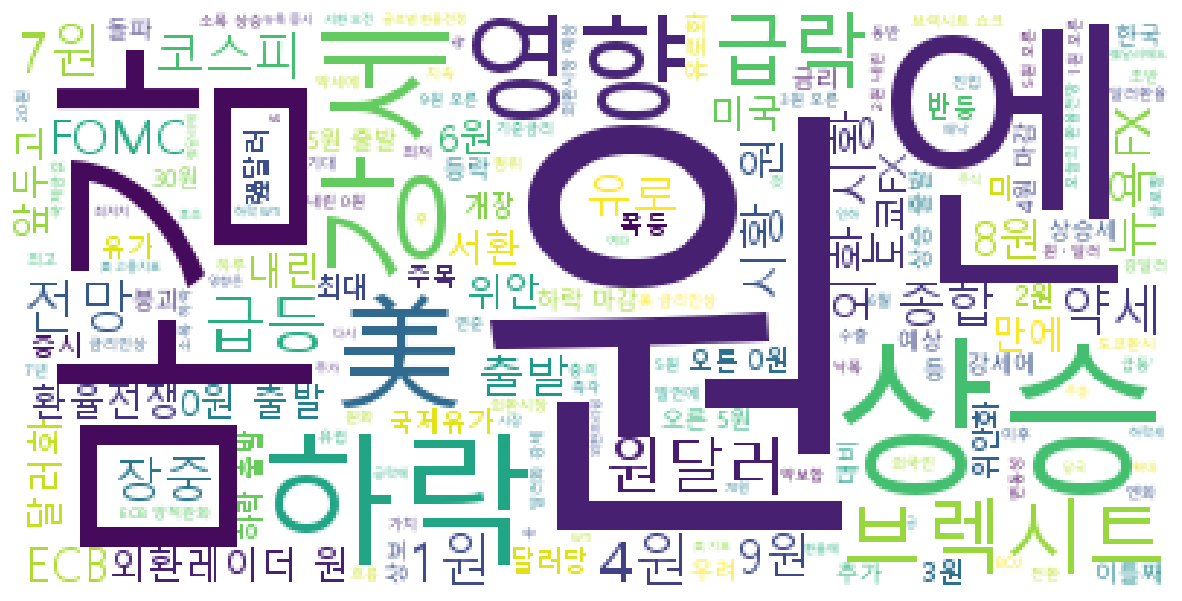

In [18]:
# 워드클라우드를 통한 핵심 키워드 시각화
text = ",".join(news_titles)
f_path = "C:\Windows\Fonts\malgun.ttf"

wc = WordCloud(font_path = f_path, random_state = 42, background_color = "white").generate(text)
plt.figure(figsize = (15, 10))
plt.axis("off")
plt.imshow(wc, interpolation = "None")
plt.show()